In [8]:
# Imports
%load_ext autoreload
%autoreload 2

import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby
from gwBackground import *
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline

from constants import *
import equations
import redshiftPrior

# Add module

sys.path.append('../../modules')
from compute_omega_mcmc import compute_injected_omega

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = 1# (1/365.25/24) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
fs = 2048 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

In [34]:
# Standard Prior Dictionary
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.PowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')

14:51 bilby INFO    : Using aligned spin prior
14:51 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [35]:
# Calculate number of injections
zs, p_dz = priors['redshift']._get_redshift_arrays()
N = redshiftPrior.calculate_num_injections(T_obs, zs, p_dz)
print(N)

71725.44902921855 Mpc3 / sr


Total number of injections: 71843


14:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-11-02 14:51:05.569 | INFO     | compute_omega_mcmc:compute_injected_omega:30 - Compute the total injected Omega for 71843 injections
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71843/71843 [00:53<00:00, 1343.54it/s]
2023-11-02 14:51:59.043 | DEBUG    | compute_omega_mcmc:compute_injected_omega:56 - Compute Omega_ref at f_ref=25 Hz
2023-11-02 14:51:59.044 | DEBUG    | compute_omega_mcmc:compute_injected_omega:61 - True f_ref=25.0
2023-11-02 14:51:59.044 | INFO     | compute_omega_mcmc:compute_injected_omega:64 - Omega_ref=4.57e-09
14:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.sourc

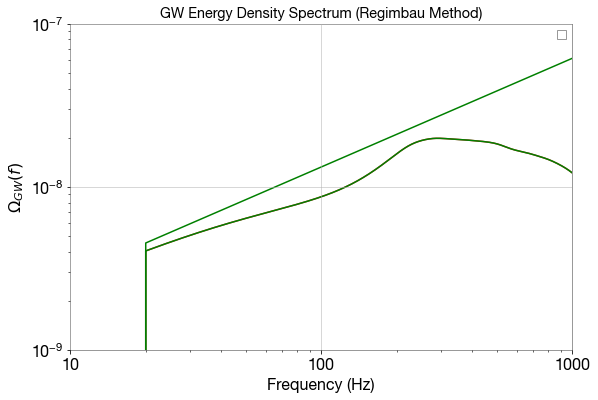

In [36]:
# Regimbau Method
N_inj = np.random.poisson(N.value)
injections = priors.sample(N_inj)
injections["signal_type"] = 'CBC'
print('Total number of injections: ' + str(N_inj))

import json
with open("test_CBC_injection_dict.json", "w") as outfile:
    json.dump(injections, outfile, indent=2, cls=bilby.core.result.BilbyJsonEncoder)

freqs_d, omega_gw_d = compute_injected_omega(injections, T_obs,
                                         return_spectrum=True,
                                         sampling_frequency=4096,
                                         duration=2)

freqs_pv2, omega_gw_pv2 = compute_injected_omega(injections, T_obs,
                                         return_spectrum=True,
                                         sampling_frequency=4096,
                                         duration=2,
                                         approximant='IMRPhenomPv2')

freqs_tf2, omega_gw_tf2 = compute_injected_omega(injections, T_obs,
                                         return_spectrum=True,
                                         sampling_frequency=4096,
                                         duration=2,
                                         approximant='TaylorF2')
    
# Plot spectrum
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.loglog(freqs_d, omega_gw_d, color='#d61c1c')
ax.loglog(freqs_pv2, omega_gw_pv2, color='green')
ax.loglog(freqs_tf2, omega_gw_tf2, color='green')
# ax.loglog(total_freqs_AR, Omega_ref_AR*(total_freqs_AR/fref)**(2/3), label='2/3 Power Law', color='#000000')

ax.set_xlim(10, 1000)
ax.set_title(r'GW Energy Density Spectrum (Regimbau Method)')
ax.set_xlabel(r'Frequency (Hz)', fontsize=16)
ax.set_ylabel(r'$\Omega_{GW}(f)$', fontsize=16)
ax.legend(fontsize=16)
plt.ylim(1e-9, 1e-7)
ax.tick_params(axis='both', labelsize=16)
ax.legend()

# print('Omega_ref at 25 Hz: ' + format(Omega_ref_AR, '.2e'))